In [1]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [2]:
import argparse
import logging
import pickle
import random

import torch
import numpy as np

import tvm
from tvm.auto_scheduler.utils import to_str_round
from tvm.auto_scheduler.cost_model import RandomModelInternal

sys.path.append("/root/work/tenset/scripts")
from common import load_and_register_tasks, str2bool
from train_model import train_zero_shot

from tvm.auto_scheduler.dataset import Dataset, LearningTask
from tvm.auto_scheduler.cost_model.xgb_model import XGBModelInternal
from tvm.auto_scheduler.cost_model.mlp_model import MLPModelInternal
from tvm.auto_scheduler.cost_model.lgbm_model import LGBModelInternal
from tvm.auto_scheduler.cost_model.tabnet_model import TabNetModelInternal
from tvm.auto_scheduler.cost_model.metric import (
    metric_rmse,
    metric_r_squared,
    metric_pairwise_comp_accuracy,
    metric_top_k_recall,
    metric_peak_score,
    metric_mape,
    random_mix,
)

load_and_register_tasks()
dataset = pickle.load(open("../../dataset.pkl", "rb"))
train_set, test_set = dataset.random_split_within_task(0.9)

tenset_model = MLPModelInternal()
tenset_model.fit_base(train_set, valid_set=test_set)

cuda:0
Fit a net. Train size: 3600
Epoch: 0	Batch: 7	Train Loss: 53.7315	Valid Loss: 29.9382	Train Speed: 12442
Epoch: 0	Batch: 7	Train Loss: 53.7315	Valid Loss: 29.9382	Train Speed: 12442
Epoch: 5	Batch: 7	Train Loss: 21.8273	Valid Loss: 5.1623	Train Speed: 85735
Epoch: 5	Batch: 7	Train Loss: 21.8273	Valid Loss: 5.1623	Train Speed: 85735
Epoch: 10	Batch: 7	Train Loss: 9.8494	Valid Loss: 3.1792	Train Speed: 75151
Epoch: 10	Batch: 7	Train Loss: 9.8494	Valid Loss: 3.1792	Train Speed: 75151
Epoch: 15	Batch: 7	Train Loss: 5.6489	Valid Loss: 2.9990	Train Speed: 69567
Epoch: 15	Batch: 7	Train Loss: 5.6489	Valid Loss: 2.9990	Train Speed: 69567
Epoch: 20	Batch: 7	Train Loss: 4.3514	Valid Loss: 2.1168	Train Speed: 73352
Epoch: 20	Batch: 7	Train Loss: 4.3514	Valid Loss: 2.1168	Train Speed: 73352
Epoch: 25	Batch: 7	Train Loss: 3.5319	Valid Loss: 1.5396	Train Speed: 72905
Epoch: 25	Batch: 7	Train Loss: 3.5319	Valid Loss: 1.5396	Train Speed: 72905
Epoch: 30	Batch: 7	Train Loss: 2.9839	Valid Loss: 1

In [3]:
# SegmentDataLoader 패턴에 맞춰 데이터 준비
raw_features = list(dataset.features.values())[0]
raw_throughputs = list(dataset.throughputs.values())[0]

# 가변 길이 features와 labels를 리스트로 저장
features_list = []  # 각 샘플의 feature (seq_len, feature_dim)
costs = []
segment_sizes_list = []  # 각 샘플의 segment 길이

for feature, throughput in zip(raw_features, raw_throughputs):
    if feature.shape[0] != 1 and throughput > 1e-10 :  # segment 길이가 1이 아닌 것만
        features_list.append(feature)
        costs.append(-np.log(throughput))
        segment_sizes_list.append(feature.shape[0])

# numpy array로 변환
costs = np.array(costs, dtype=np.float32)
segment_sizes = np.array(segment_sizes_list, dtype=np.int32)

# 모든 features를 flatten (SegmentDataLoader 방식)
flatten_features = np.concatenate(features_list, axis=0).astype(np.float32)

print(f"총 샘플 수: {len(costs)}")
print(f"Flatten된 features shape: {flatten_features.shape}")
print(f"Segment sizes - Min: {segment_sizes.min()}, Max: {segment_sizes.max()}, Mean: {segment_sizes.mean():.2f}")

총 샘플 수: 3464
Flatten된 features shape: (27712, 164)
Segment sizes - Min: 8, Max: 8, Mean: 8.00


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentRegressionDataset:
    """SegmentDataLoader 패턴을 따르는 데이터셋"""
    def __init__(self, segment_sizes, features, labels, batch_size, device, 
                 fea_norm_vec=None, shuffle=False, seed=42):
        self.device = device
        self.shuffle = shuffle
        self.seed = seed
        self.number = len(labels)
        self.batch_size = batch_size
        
        self.segment_sizes = torch.tensor(segment_sizes, dtype=torch.int32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.features = torch.tensor(features, dtype=torch.float32)
        
        if fea_norm_vec is not None:
            self.normalize(fea_norm_vec)
        
        self.feature_offsets = (
            torch.cumsum(self.segment_sizes, 0, dtype=torch.int32) - self.segment_sizes
        ).cpu().numpy()
        
        self.iter_order = self.pointer = None
        self.rng = np.random.RandomState(seed)
    
    def normalize(self, norm_vector=None):
        if norm_vector is None:
            norm_vector = torch.ones((self.features.shape[1],))
            for i in range(self.features.shape[1]):
                max_val = self.features[:, i].max().item()
                if max_val > 0:
                    norm_vector[i] = max_val
        self.features /= norm_vector
        return norm_vector
    
    def __iter__(self):
        if self.shuffle:
            self.iter_order = torch.from_numpy(self.rng.permutation(self.number))
        else:
            self.iter_order = torch.arange(self.number)
        self.pointer = 0
        return self
    
    def __next__(self):
        if self.pointer >= self.number:
            raise StopIteration
        
        batch_indices = self.iter_order[self.pointer: self.pointer + self.batch_size]
        self.pointer += self.batch_size
        return self._fetch_indices(batch_indices)
    
    def _fetch_indices(self, indices):
        segment_sizes = self.segment_sizes[indices]
        
        feature_offsets = self.feature_offsets[indices]
        feature_indices = np.empty((segment_sizes.sum().item(),), dtype=np.int32)
        ct = 0
        for offset, seg_size in zip(feature_offsets, segment_sizes.numpy()):
            feature_indices[ct: ct + seg_size] = np.arange(offset, offset + seg_size, 1)
            ct += seg_size
        
        features = self.features[feature_indices]
        labels = self.labels[indices]
        return (x.to(self.device) for x in (segment_sizes, features, labels))
    
    def __len__(self):
        return self.number


# Train/Val 분할
n_samples = len(costs)
indices = np.arange(n_samples)
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=SEED)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features_list[i] for i in train_indices]
val_feature_list = [features_list[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

print(f"훈련 샘플 수: {len(train_labels)}, 검증 샘플 수: {len(val_labels)}")
print(f"훈련 flatten features: {train_flatten_features.shape}")
print(f"검증 flatten features: {val_flatten_features.shape}")

# 정규화
fea_norm_vec = torch.ones((train_flatten_features.shape[1],))
for i in range(train_flatten_features.shape[1]):
    max_val = float(train_flatten_features[:, i].max())
    if max_val > 0:
        fea_norm_vec[i] = max_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = SegmentRegressionDataset(
    train_segment_sizes, train_flatten_features, train_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=True, seed=SEED
)
val_loader = SegmentRegressionDataset(
    val_segment_sizes, val_flatten_features, val_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)

X_train = train_flatten_features
X_val = val_flatten_features
y_train = train_labels
y_val = val_labels
train_dataset = train_loader
val_dataset = val_loader

훈련 샘플 수: 2771, 검증 샘플 수: 693
훈련 flatten features: (22168, 164)
검증 flatten features: (5544, 164)


## VAE Feature Pre-training (Reconstruction + β·KLD)

Feature만 입력으로 사용하여 VAE encoder representation을 먼저 학습합니다.
- Reconstruction loss: MSE로 원본 feature를 복원
- KL Divergence: latent 분포를 N(0, I)에 가깝게 정규화
- β 자동 탐색: 1e-3~1e-2 범위에서 최적값 탐색

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import r2_score
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentVAE(nn.Module):
    """
    Segment-level VAE:
    1. Segment Encoder: 각 row를 hidden_dim으로 변환
    2. Segment Sum: row들을 segment별로 합산
    3. VAE: 합산된 벡터를 encode → decode (reconstruction)
    """
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, dropout=0.1):
        super(SegmentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Segment Encoder (VAE 전에 적용) ==========
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # ========== VAE Encoder (segment sum 후 적용) ==========
        self.norm = nn.BatchNorm1d(hidden_dim)
        
        # Residual 레이어들
        self.l0 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.l1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE latent parameters
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== VAE Decoder (hidden_dim으로 reconstruction) ==========
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # 출력: segment sum 벡터 (hidden_dim)
        )
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, h):
        """VAE Encoder: segment sum 벡터 → (mean, logvar)"""
        # BatchNorm
        h = self.norm(h)
        
        # Residual connections
        h = self.l0(h) + h
        h = self.l1(h) + h
        
        # Latent parameters
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        """VAE Decoder: latent z → reconstructed segment sum 벡터"""
        return self.decoder(z)
    
    def forward(self, segment_sizes, features):
        """
        Forward pass:
        1. Segment Encoder: features → hidden
        2. Segment Sum: hidden → segment-level 벡터
        3. VAE: encode → reparameterize → decode
        """
        # 1. Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # 2. Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # 3. VAE Encode
        mean, logvar = self.encode(segment_sum_vec)
        
        # 4. Reparameterize
        z = self.reparameterize(mean, logvar)
        
        # 5. VAE Decode (reconstruct segment sum 벡터)
        recon = self.decode(z)  # (n_seg, hidden_dim)
        
        return mean, logvar, z, recon, segment_sum_vec


def vae_loss(recon, original, mean, logvar, beta):
    """
    VAE Loss = Reconstruction Loss + β * KL Divergence
    - Reconstruction: MSE between original and reconstructed segment sum 벡터
    - KLD: D_KL(q(z|x) || p(z)), where p(z) = N(0, I)
    """
    recon_loss = F.mse_loss(recon, original, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kld_loss
    return total_loss, recon_loss, kld_loss


print("Segment VAE 모델 정의 완료!")
print(f"- Input dim: {train_flatten_features.shape[1]}")
print(f"- Hidden dim: 256")
print(f"- Latent dim: 64")
print("Flow: features → segment_encoder → segment_sum → VAE (encode/decode)")

Segment VAE 모델 정의 완료!
- Input dim: 164
- Hidden dim: 256
- Latent dim: 64
Flow: features → segment_encoder → segment_sum → VAE (encode/decode)


In [29]:
# 하이퍼파라미터 탐색을 위한 VAE 학습 함수
# KL/latent_dim이 0.05~0.2 범위에 있도록 우선 조정

def train_vae_single_config(train_loader, val_loader, input_dim, device,
                            hidden_dim, latent_dim, beta, lr, dropout=0.1,
                            num_epochs=300, patience=40, verbose=False):
    """단일 설정으로 VAE 학습"""
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    model = SegmentVAE(input_dim, hidden_dim, latent_dim, dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)
    
    best_recon_r2 = -float('inf')
    patience_counter = 0
    best_state = None
    history = {'recon_r2': [], 'kl_per_dim': [], 'recon_loss': []}
    
    for epoch in range(num_epochs):
        model.train()
        epoch_kl = 0.0
        epoch_recon = 0.0
        n_batches = 0
        
        for segment_sizes_batch, features_batch, _ in train_loader:
            mean, logvar, z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
            loss, recon_loss, kld_loss = vae_loss(recon, segment_sum_vec, mean, logvar, beta)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # KL per dimension 계산 (평균)
            batch_kl_per_dim = kld_loss.item() / (mean.shape[0] * latent_dim)
            epoch_kl += batch_kl_per_dim
            epoch_recon += recon_loss.item() / mean.shape[0]
            n_batches += 1
        
        scheduler.step()
        avg_kl_per_dim = epoch_kl / n_batches
        avg_recon = epoch_recon / n_batches
        
        # Validation
        model.eval()
        val_recons, val_originals = [], []
        val_kl_per_dim = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for segment_sizes_batch, features_batch, _ in val_loader:
                mean, logvar, z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
                kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                val_kl_per_dim += kld.item() / (mean.shape[0] * latent_dim)
                val_batches += 1
                val_recons.append(recon.cpu().numpy())
                val_originals.append(segment_sum_vec.cpu().numpy())
        
        val_kl_per_dim /= val_batches
        recon_r2 = r2_score(
            np.concatenate(val_originals).flatten(),
            np.concatenate(val_recons).flatten()
        )
        
        history['recon_r2'].append(recon_r2)
        history['kl_per_dim'].append(val_kl_per_dim)
        history['recon_loss'].append(avg_recon)
        
        if recon_r2 > best_recon_r2:
            best_recon_r2 = recon_r2
            patience_counter = 0
            best_state = model.state_dict().copy()
            best_kl_per_dim = val_kl_per_dim
        else:
            patience_counter += 1
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}: R²={recon_r2:.4f}, KL/dim={val_kl_per_dim:.4f}")
        
        if patience_counter >= patience:
            break
    
    model.load_state_dict(best_state)
    return model, best_recon_r2, best_kl_per_dim, history


def hyperparameter_search(train_loader, val_loader, input_dim, device,
                          target_kl_range=(0.05, 0.2), target_r2=0.95,
                          num_epochs=300, patience=40):
    """
    하이퍼파라미터 탐색:
    - KL/latent_dim이 0.05~0.2 범위에 있도록 우선 조정
    - 범위를 벗어나면 페널티 부여
    """
    
    # 하이퍼파라미터 그리드
    # hidden_dims = [256, 512]
    # latent_dims = [64, 128, 256]
    # betas = [1e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3]
    # lrs = [1e-3, 5e-4, 2e-4]
    hidden_dims = [256]
    latent_dims = [64]
    betas = [2e-4]
    lrs = [5e-04]
    
    print("=" * 70)
    print("VAE 하이퍼파라미터 탐색")
    print("=" * 70)
    print(f"목표 KL/dim 범위: {target_kl_range}")
    print(f"목표 R²: >= {target_r2}")
    print(f"Hidden dims: {hidden_dims}")
    print(f"Latent dims: {latent_dims}")
    print(f"β values: {betas}")
    print(f"Learning rates: {lrs}")
    print()
    
    all_results = []
    best_score = -float('inf')
    best_config = None
    best_model = None
    
    total_configs = len(hidden_dims) * len(latent_dims) * len(betas) * len(lrs)
    config_idx = 0
    
    for hidden_dim in hidden_dims:
        for latent_dim in latent_dims:
            for beta in betas:
                for lr in lrs:
                    config_idx += 1
                    config = {
                        'hidden_dim': hidden_dim,
                        'latent_dim': latent_dim,
                        'beta': beta,
                        'lr': lr
                    }
                    
                    print(f"\n[{config_idx}/{total_configs}] hidden={hidden_dim}, latent={latent_dim}, β={beta:.0e}, lr={lr:.0e}")
                    
                    try:
                        model, recon_r2, kl_per_dim, history = train_vae_single_config(
                            train_loader, val_loader, input_dim, device,
                            hidden_dim=hidden_dim,
                            latent_dim=latent_dim,
                            beta=beta,
                            lr=lr,
                            num_epochs=num_epochs,
                            patience=patience,
                            verbose=False
                        )
                        
                        # KL/dim 범위 체크
                        kl_min, kl_max = target_kl_range
                        in_kl_range = kl_min <= kl_per_dim <= kl_max
                        
                        # 스코어 계산: R² 기준, KL 범위 벗어나면 페널티
                        if in_kl_range:
                            score = recon_r2
                            kl_status = "✓"
                        else:
                            # 범위를 벗어난 정도에 따라 페널티
                            if kl_per_dim < kl_min:
                                penalty = (kl_min - kl_per_dim) / kl_min
                            else:
                                penalty = (kl_per_dim - kl_max) / kl_max
                            score = recon_r2 - penalty * 0.1  # 최대 10% 페널티
                            kl_status = "✗"
                        
                        result = {
                            **config,
                            'recon_r2': recon_r2,
                            'kl_per_dim': kl_per_dim,
                            'in_kl_range': in_kl_range,
                            'score': score,
                            'model': model,
                            'history': history
                        }
                        all_results.append(result)
                        
                        print(f"  → R²={recon_r2:.4f}, KL/dim={kl_per_dim:.4f} {kl_status}, Score={score:.4f}")
                        
                        if score > best_score:
                            best_score = score
                            best_config = config
                            best_model = model
                            best_result = result
                            print(f"  ★ 새로운 최고!")
                        
                    except Exception as e:
                        print(f"  오류: {e}")
                        continue
    
    # 결과 정렬 및 출력
    print("\n" + "=" * 70)
    print("탐색 결과 (Score 기준 상위 10개)")
    print("=" * 70)
    
    sorted_results = sorted(all_results, key=lambda x: x['score'], reverse=True)
    
    print(f"{'Rank':<5} {'Hidden':<8} {'Latent':<8} {'β':<10} {'LR':<10} {'R²':<8} {'KL/dim':<10} {'KL범위':<8} {'Score':<8}")
    print("-" * 85)
    
    for i, res in enumerate(sorted_results[:10]):
        kl_status = "✓" if res['in_kl_range'] else "✗"
        print(f"{i+1:<5} {res['hidden_dim']:<8} {res['latent_dim']:<8} {res['beta']:<10.0e} {res['lr']:<10.0e} {res['recon_r2']:<8.4f} {res['kl_per_dim']:<10.4f} {kl_status:<8} {res['score']:<8.4f}")
    
    print("\n" + "=" * 70)
    print("최적 설정")
    print("=" * 70)
    print(f"Hidden dim: {best_config['hidden_dim']}")
    print(f"Latent dim: {best_config['latent_dim']}")
    print(f"β: {best_config['beta']}")
    print(f"Learning rate: {best_config['lr']}")
    print(f"Reconstruction R²: {best_result['recon_r2']:.4f}")
    print(f"KL/dim: {best_result['kl_per_dim']:.4f}")
    print(f"KL 범위 내: {'예' if best_result['in_kl_range'] else '아니오'}")
    
    return best_model, best_config, sorted_results


print("하이퍼파라미터 탐색 함수 정의 완료!")

하이퍼파라미터 탐색 함수 정의 완료!


In [30]:
# VAE 하이퍼파라미터 탐색 실행
print("=" * 60)
print("VAE 하이퍼파라미터 탐색 시작")
print("=" * 60)

input_dim = train_flatten_features.shape[1]

pretrained_vae, best_config, all_results = hyperparameter_search(
    train_loader, val_loader, input_dim, device,
    target_kl_range=(0.05, 0.2),
    target_r2=0.95,
    num_epochs=300,
    patience=40
)

# 최적 β 저장 (시각화용)
best_beta = best_config['beta']

print("\n" + "=" * 60)
print("VAE 하이퍼파라미터 탐색 완료!")
print("=" * 60)

VAE 하이퍼파라미터 탐색 시작
VAE 하이퍼파라미터 탐색
목표 KL/dim 범위: (0.05, 0.2)
목표 R²: >= 0.95
Hidden dims: [256]
Latent dims: [64]
β values: [0.0002]
Learning rates: [0.0005]


[1/1] hidden=256, latent=64, β=2e-04, lr=5e-04
  → R²=0.9847, KL/dim=0.1702 ✓, Score=0.9847
  ★ 새로운 최고!

탐색 결과 (Score 기준 상위 10개)
Rank  Hidden   Latent   β          LR         R²       KL/dim     KL범위     Score   
-------------------------------------------------------------------------------------
1     256      64       2e-04      5e-04      0.9847   0.1702     ✓        0.9847  

최적 설정
Hidden dim: 256
Latent dim: 64
β: 0.0002
Learning rate: 0.0005
Reconstruction R²: 0.9847
KL/dim: 0.1702
KL 범위 내: 예

VAE 하이퍼파라미터 탐색 완료!


/tmp/ipykernel_569/2514426029.py:123: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_569/2514426029.py:123: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_569/2514426029.py:123: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_569/2514426029.py:123: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_569/2514426029.py:123: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_569/2514426029.py:123: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_569/2514426029.py:123: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_569/2514426029.py:1

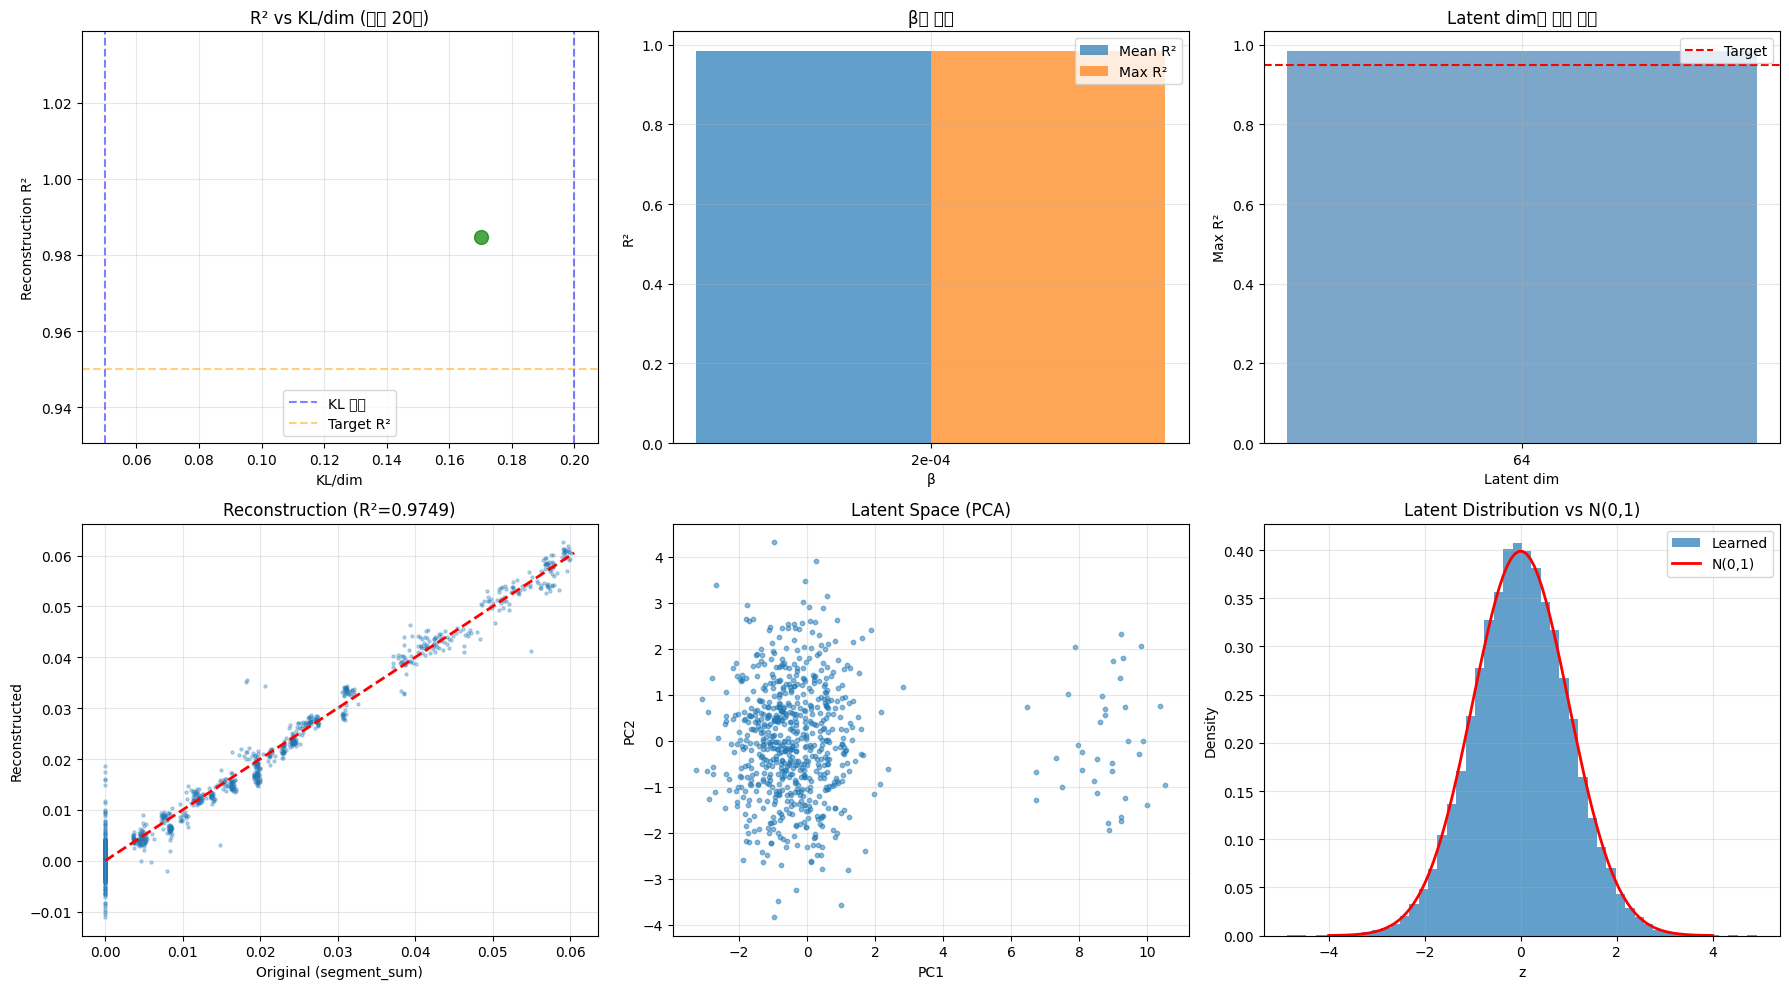


최적 설정: hidden=256, latent=64, β=2e-04, lr=5e-04
최종 Reconstruction R²: 0.9749


In [31]:
# VAE 하이퍼파라미터 탐색 결과 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 상위 결과들의 R² vs KL/dim
ax = axes[0, 0]
top_results = all_results[:20]  # 상위 20개
r2_vals = [r['recon_r2'] for r in top_results]
kl_vals = [r['kl_per_dim'] for r in top_results]
in_range = [r['in_kl_range'] for r in top_results]
colors = ['green' if ir else 'red' for ir in in_range]

ax.scatter(kl_vals, r2_vals, c=colors, s=100, alpha=0.7)
ax.axvline(x=0.05, color='blue', linestyle='--', alpha=0.5, label='KL 범위')
ax.axvline(x=0.2, color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='Target R²')
ax.set_xlabel('KL/dim')
ax.set_ylabel('Reconstruction R²')
ax.set_title('R² vs KL/dim (상위 20개)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. β별 성능 비교
ax = axes[0, 1]
beta_groups = {}
for r in all_results:
    b = r['beta']
    if b not in beta_groups:
        beta_groups[b] = []
    beta_groups[b].append(r['recon_r2'])

betas_sorted = sorted(beta_groups.keys())
beta_labels = [f'{b:.0e}' for b in betas_sorted]
beta_r2_means = [np.mean(beta_groups[b]) for b in betas_sorted]
beta_r2_maxs = [np.max(beta_groups[b]) for b in betas_sorted]

x_pos = np.arange(len(betas_sorted))
ax.bar(x_pos - 0.2, beta_r2_means, 0.4, label='Mean R²', alpha=0.7)
ax.bar(x_pos + 0.2, beta_r2_maxs, 0.4, label='Max R²', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(beta_labels)
ax.set_xlabel('β')
ax.set_ylabel('R²')
ax.set_title('β별 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Latent dim별 성능 비교
ax = axes[0, 2]
latent_groups = {}
for r in all_results:
    ld = r['latent_dim']
    if ld not in latent_groups:
        latent_groups[ld] = {'r2': [], 'kl': []}
    latent_groups[ld]['r2'].append(r['recon_r2'])
    latent_groups[ld]['kl'].append(r['kl_per_dim'])

latent_sorted = sorted(latent_groups.keys())
latent_labels = [str(ld) for ld in latent_sorted]
latent_r2_maxs = [np.max(latent_groups[ld]['r2']) for ld in latent_sorted]

ax.bar(latent_labels, latent_r2_maxs, alpha=0.7, color='steelblue')
ax.axhline(y=0.95, color='red', linestyle='--', label='Target')
ax.set_xlabel('Latent dim')
ax.set_ylabel('Max R²')
ax.set_title('Latent dim별 최고 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. 최적 모델 Reconstruction 품질
pretrained_vae.eval()
val_recons, val_originals = [], []
with torch.no_grad():
    for segment_sizes_batch, features_batch, _ in val_loader:
        mean, logvar, z, recon, segment_sum_vec = pretrained_vae(segment_sizes_batch, features_batch)
        val_recons.append(recon.cpu().numpy())
        val_originals.append(segment_sum_vec.cpu().numpy())

val_recons_flat = np.concatenate(val_recons).flatten()
val_originals_flat = np.concatenate(val_originals).flatten()

ax = axes[1, 0]
sample_idx = np.random.choice(len(val_originals_flat), min(5000, len(val_originals_flat)), replace=False)
ax.scatter(val_originals_flat[sample_idx], val_recons_flat[sample_idx], alpha=0.3, s=5)
ax.plot([val_originals_flat.min(), val_originals_flat.max()], 
        [val_originals_flat.min(), val_originals_flat.max()], 'r--', lw=2)
ax.set_xlabel('Original (segment_sum)')
ax.set_ylabel('Reconstructed')
final_r2 = r2_score(val_originals_flat, val_recons_flat)
ax.set_title(f'Reconstruction (R²={final_r2:.4f})')
ax.grid(True, alpha=0.3)

# 5. Latent space 시각화
all_z = []
with torch.no_grad():
    for segment_sizes_batch, features_batch, _ in val_loader:
        _, _, z, _, _ = pretrained_vae(segment_sizes_batch, features_batch)
        all_z.append(z.cpu().numpy())
all_z = np.concatenate(all_z)

ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(all_z)
ax.scatter(z_2d[:, 0], z_2d[:, 1], alpha=0.5, s=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Latent Space (PCA)')
ax.grid(True, alpha=0.3)

# 6. Latent 분포 히스토그램
ax = axes[1, 2]
ax.hist(all_z.flatten(), bins=50, density=True, alpha=0.7, label='Learned')
x = np.linspace(-4, 4, 100)
ax.plot(x, np.exp(-x**2/2) / np.sqrt(2*np.pi), 'r-', lw=2, label='N(0,1)')
ax.set_xlabel('z')
ax.set_ylabel('Density')
ax.set_title('Latent Distribution vs N(0,1)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n최적 설정: hidden={best_config['hidden_dim']}, latent={best_config['latent_dim']}, β={best_config['beta']:.0e}, lr={best_config['lr']:.0e}")
print(f"최종 Reconstruction R²: {final_r2:.4f}")

In [32]:
# VAE 모델 저장
import os

# 최적 결과 찾기 (all_results의 첫 번째 항목이 최고)
best_result = all_results[0]
print("최적 결과:", best_result)

# 저장 경로 설정
save_dir = '/root/work/tenset/scripts/pre_experiments/model_mid/checkpoints'
os.makedirs(save_dir, exist_ok=True)

# 모델 및 설정 저장
checkpoint = {
    'model_state_dict': pretrained_vae.state_dict(),
    'config': {
        'hidden_dim': best_result['hidden_dim'],
        'latent_dim': best_result['latent_dim'],
        'beta': best_result['beta'],
        'lr': best_result['lr'],
    },
    'metrics': {
        'recon_r2': best_result['recon_r2'],
        'kl_per_dim': best_result['kl_per_dim'],
        'in_kl_range': best_result['in_kl_range'],
        'score': best_result['score']
    },
    'search_results': all_results[:20]  # 상위 20개 결과 저장
}

save_path = os.path.join(save_dir, 'vae_feature_encoder.pt')
torch.save(checkpoint, save_path)
print(f"\n✓ VAE 모델 저장 완료: {save_path}")
print(f"\n저장된 설정:")
print(f"  - Hidden dim: {checkpoint['config']['hidden_dim']}")
print(f"  - Latent dim: {checkpoint['config']['latent_dim']}")
print(f"  - β: {checkpoint['config']['beta']:.0e}")
print(f"  - Learning rate: {checkpoint['config']['lr']:.0e}")
print(f"  - Reconstruction R²: {checkpoint['metrics']['recon_r2']:.4f}")
print(f"  - KL/dim: {checkpoint['metrics']['kl_per_dim']:.4f}")
print(f"  - KL 범위 내: {'예' if checkpoint['metrics']['in_kl_range'] else '아니오'}")

최적 결과: {'hidden_dim': 256, 'latent_dim': 64, 'beta': 0.0002, 'lr': 0.0005, 'recon_r2': 0.9846680658067904, 'kl_per_dim': 0.17015100607894504, 'in_kl_range': True, 'score': 0.9846680658067904, 'model': SegmentVAE(
  (segment_encoder): Sequential(
    (0): Linear(in_features=164, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l0): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (l1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

## Regression with Pre-trained VAE Encoder

사전학습된 VAE encoder를 사용하여 regression 모델을 학습합니다.
- VAE encoder의 latent representation (z)을 사용
- Regression head만 추가하여 cost 예측

In [9]:
class VAERegressor(nn.Module):
    """
    사전학습된 VAE encoder를 사용하는 Regression 모델
    - Encoder weights는 freeze 또는 fine-tune 가능
    - Regression head를 추가하여 cost 예측
    """
    def __init__(self, pretrained_vae, hidden_dim=256, dropout=0.1, freeze_encoder=False):
        super(VAERegressor, self).__init__()
        
        # 사전학습된 VAE encoder 복사
        self.segment_encoder = pretrained_vae.segment_encoder
        self.norm = pretrained_vae.norm
        self.l0 = pretrained_vae.l0
        self.l1 = pretrained_vae.l1
        self.fc_mean = pretrained_vae.fc_mean
        self.fc_logvar = pretrained_vae.fc_logvar
        
        latent_dim = pretrained_vae.latent_dim
        
        # Encoder freeze 옵션
        if freeze_encoder:
            for param in self.segment_encoder.parameters():
                param.requires_grad = False
            for param in self.norm.parameters():
                param.requires_grad = False
            for param in self.l0.parameters():
                param.requires_grad = False
            for param in self.l1.parameters():
                param.requires_grad = False
            for param in self.fc_mean.parameters():
                param.requires_grad = False
            for param in self.fc_logvar.parameters():
                param.requires_grad = False
        
        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            
            nn.Linear(hidden_dim // 4, 1),
        )
        
    def segment_sum(self, segment_sizes, features):
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, segment_sizes, features):
        h = self.segment_encoder(features)
        h = self.segment_sum(segment_sizes, h)
        h = self.norm(h)
        h = self.l0(h) + h
        h = self.l1(h) + h
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, segment_sizes, features, use_mean=False):
        """
        Forward pass
        - use_mean=True: 평가 시 mean만 사용 (deterministic)
        - use_mean=False: reparameterization trick 사용 (학습 시)
        """
        mean, logvar = self.encode(segment_sizes, features)
        
        if use_mean:
            z = mean
        else:
            z = self.reparameterize(mean, logvar)
        
        cost = self.regression_head(z)
        return mean, logvar, cost


def train_regressor(model, train_loader, val_loader, device, 
                    num_epochs=500, patience=50, lr=3e-4, beta_kl=0.001):
    """
    Regression 모델 학습
    - Huber Loss for regression
    - Optional: KL regularization 유지
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)
    
    best_val_r2 = -float('inf')
    patience_counter = 0
    best_state = None
    
    history = {'train_loss': [], 'val_loss': [], 'val_r2': [], 'lr': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        n_samples = 0
        
        for segment_sizes_batch, features_batch, labels_batch in train_loader:
            labels_batch = labels_batch.unsqueeze(1) if labels_batch.ndim == 1 else labels_batch
            
            mean, logvar, cost_pred = model(segment_sizes_batch, features_batch, use_mean=False)
            
            # Huber Loss
            reg_loss = F.smooth_l1_loss(cost_pred, labels_batch, reduction='sum')
            
            # KL regularization (작은 가중치)
            kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            
            loss = reg_loss + beta_kl * kl_loss
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            n_samples += labels_batch.shape[0]
        
        train_loss /= n_samples
        scheduler.step()
        
        # Validation
        model.eval()
        val_preds = []
        val_targets = []
        val_loss = 0.0
        val_n_samples = 0
        
        with torch.no_grad():
            for segment_sizes_batch, features_batch, labels_batch in val_loader:
                labels_batch = labels_batch.unsqueeze(1) if labels_batch.ndim == 1 else labels_batch
                
                # 평가 시에는 mean 사용 (deterministic)
                mean, logvar, cost_pred = model(segment_sizes_batch, features_batch, use_mean=True)
                
                reg_loss = F.smooth_l1_loss(cost_pred, labels_batch, reduction='sum')
                val_loss += reg_loss.item()
                val_n_samples += labels_batch.shape[0]
                
                val_preds.append(cost_pred.cpu().numpy())
                val_targets.append(labels_batch.cpu().numpy())
        
        val_loss /= val_n_samples
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_r2 = r2_score(val_targets, val_preds)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_r2'].append(val_r2)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Val R²: {val_r2:.4f} (Best: {best_val_r2:.4f})")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_state)
    return model, history, best_val_r2


print("Regression 모델 정의 완료!")

Regression 모델 정의 완료!


In [10]:
# Regression 학습 실행 (R² >= 0.98 목표)
print("=" * 60)
print("Regression 학습 시작 (사전학습된 VAE encoder 사용)")
print("=" * 60)
print("목표: R² >= 0.98")
print()

# 1차 시도: Encoder freeze (사전학습된 representation 그대로 사용)
print("\n--- 1차 시도: Encoder Freeze ---")
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

regressor_frozen = VAERegressor(pretrained_vae, hidden_dim=256, dropout=0.1, freeze_encoder=True).to(device)
regressor_frozen, history_frozen, best_r2_frozen = train_regressor(
    regressor_frozen, train_loader, val_loader, device,
    num_epochs=500, patience=80, lr=1e-3, beta_kl=0.0
)
print(f"Encoder Freeze 결과: R² = {best_r2_frozen:.4f}")

# 2차 시도: Encoder fine-tune (더 좋은 결과 기대)
print("\n--- 2차 시도: Encoder Fine-tune ---")
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

regressor_finetune = VAERegressor(pretrained_vae, hidden_dim=256, dropout=0.1, freeze_encoder=False).to(device)
regressor_finetune, history_finetune, best_r2_finetune = train_regressor(
    regressor_finetune, train_loader, val_loader, device,
    num_epochs=500, patience=80, lr=3e-4, beta_kl=0.001
)
print(f"Encoder Fine-tune 결과: R² = {best_r2_finetune:.4f}")

# 더 나은 모델 선택
if best_r2_finetune >= best_r2_frozen:
    best_regressor = regressor_finetune
    best_history = history_finetune
    best_r2 = best_r2_finetune
    best_method = "Fine-tune"
else:
    best_regressor = regressor_frozen
    best_history = history_frozen
    best_r2 = best_r2_frozen
    best_method = "Frozen"

print(f"\n최적 모델: {best_method}, R² = {best_r2:.4f}")

# R² < 0.98이면 추가 개선 시도
if best_r2 < 0.98:
    print(f"\n목표 미달성. 추가 개선 시도...")

Regression 학습 시작 (사전학습된 VAE encoder 사용)
목표: R² >= 0.98


--- 1차 시도: Encoder Freeze ---
Epoch [50/500] Train Loss: 0.0600, Val R²: 0.9521 (Best: 0.9523)
Epoch [100/500] Train Loss: 0.0530, Val R²: 0.9505 (Best: 0.9523)
Epoch [150/500] Train Loss: 0.0483, Val R²: 0.9563 (Best: 0.9569)
Epoch [200/500] Train Loss: 0.0523, Val R²: 0.9519 (Best: 0.9569)
Early stopping at epoch 221
Encoder Freeze 결과: R² = 0.9569

--- 2차 시도: Encoder Fine-tune ---
Epoch [50/500] Train Loss: 0.2438, Val R²: 0.9406 (Best: 0.9406)
Epoch [100/500] Train Loss: 0.2233, Val R²: 0.9476 (Best: 0.9496)
Epoch [150/500] Train Loss: 0.2223, Val R²: 0.9492 (Best: 0.9519)
Epoch [200/500] Train Loss: 0.2097, Val R²: 0.9523 (Best: 0.9523)
Epoch [250/500] Train Loss: 0.2063, Val R²: 0.9520 (Best: 0.9541)
Epoch [300/500] Train Loss: 0.2093, Val R²: 0.9556 (Best: 0.9556)
Epoch [350/500] Train Loss: 0.2022, Val R²: 0.9543 (Best: 0.9560)
Epoch [400/500] Train Loss: 0.2075, Val R²: 0.9533 (Best: 0.9560)
Early stopping at epoch 413
En

In [11]:
# 개선된 모델 구조와 학습 전략으로 R² >= 0.98 달성 시도
class EnhancedVAERegressor(nn.Module):
    """
    더 깊고 넓은 regression head + residual connections
    """
    def __init__(self, pretrained_vae, hidden_dim=512, dropout=0.15):
        super(EnhancedVAERegressor, self).__init__()
        
        # 사전학습된 VAE encoder
        self.segment_encoder = pretrained_vae.segment_encoder
        self.norm = pretrained_vae.norm
        self.l0 = pretrained_vae.l0
        self.l1 = pretrained_vae.l1
        self.fc_mean = pretrained_vae.fc_mean
        self.fc_logvar = pretrained_vae.fc_logvar
        
        latent_dim = pretrained_vae.latent_dim
        
        # Enhanced Regression head with residual
        self.proj = nn.Linear(latent_dim, hidden_dim)
        self.proj_bn = nn.BatchNorm1d(hidden_dim)
        
        self.res_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
            ) for _ in range(3)
        ])
        
        self.final_head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_dim // 2, 1),
        )
        
    def segment_sum(self, segment_sizes, features):
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, segment_sizes, features):
        h = self.segment_encoder(features)
        h = self.segment_sum(segment_sizes, h)
        h = self.norm(h)
        h = self.l0(h) + h
        h = self.l1(h) + h
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar
    
    def forward(self, segment_sizes, features, use_mean=False):
        mean, logvar = self.encode(segment_sizes, features)
        
        if use_mean:
            z = mean
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mean + eps * std
        
        # Enhanced regression
        h = F.relu(self.proj_bn(self.proj(z)))
        
        for res_block in self.res_blocks:
            h = F.relu(res_block(h) + h)
        
        cost = self.final_head(h)
        return mean, logvar, cost


def iterative_improvement(pretrained_vae, train_loader, val_loader, device, target_r2=0.98, max_iterations=5):
    """
    R² >= target_r2가 될 때까지 반복적으로 개선
    """
    print("=" * 60)
    print(f"반복적 개선 시작 (목표: R² >= {target_r2})")
    print("=" * 60)
    
    configs = [
        # (hidden_dim, dropout, lr, beta_kl, epochs, patience)
        (512, 0.1, 3e-4, 0.001, 500, 80),
        (768, 0.15, 2e-4, 0.0005, 600, 100),
        (1024, 0.1, 1e-4, 0.0001, 700, 120),
        (512, 0.05, 5e-4, 0.001, 500, 80),
        (768, 0.2, 3e-4, 0.002, 600, 100),
    ]
    
    best_overall_r2 = -float('inf')
    best_overall_model = None
    best_overall_history = None
    best_config = None
    
    for i, (hidden_dim, dropout, lr, beta_kl, epochs, patience) in enumerate(configs):
        if best_overall_r2 >= target_r2:
            print(f"\n목표 R² 달성! 반복 중단.")
            break
        
        print(f"\n--- 시도 {i+1}/{len(configs)} ---")
        print(f"Config: hidden={hidden_dim}, dropout={dropout}, lr={lr}, beta_kl={beta_kl}")
        
        torch.manual_seed(SEED + i)
        np.random.seed(SEED + i)
        random.seed(SEED + i)
        
        model = EnhancedVAERegressor(pretrained_vae, hidden_dim, dropout).to(device)
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)
        
        best_val_r2 = -float('inf')
        patience_counter = 0
        best_state = None
        history = {'train_loss': [], 'val_loss': [], 'val_r2': []}
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            n_samples = 0
            
            for segment_sizes_batch, features_batch, labels_batch in train_loader:
                labels_batch = labels_batch.unsqueeze(1) if labels_batch.ndim == 1 else labels_batch
                
                mean, logvar, cost_pred = model(segment_sizes_batch, features_batch)
                
                reg_loss = F.smooth_l1_loss(cost_pred, labels_batch, reduction='sum')
                kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                loss = reg_loss + beta_kl * kl_loss
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
                n_samples += labels_batch.shape[0]
            
            train_loss /= n_samples
            scheduler.step()
            
            model.eval()
            val_preds = []
            val_targets = []
            val_loss = 0.0
            val_n = 0
            
            with torch.no_grad():
                for segment_sizes_batch, features_batch, labels_batch in val_loader:
                    labels_batch = labels_batch.unsqueeze(1) if labels_batch.ndim == 1 else labels_batch
                    mean, logvar, cost_pred = model(segment_sizes_batch, features_batch, use_mean=True)
                    val_loss += F.smooth_l1_loss(cost_pred, labels_batch, reduction='sum').item()
                    val_n += labels_batch.shape[0]
                    val_preds.append(cost_pred.cpu().numpy())
                    val_targets.append(labels_batch.cpu().numpy())
            
            val_loss /= val_n
            val_r2 = r2_score(np.concatenate(val_targets), np.concatenate(val_preds))
            
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_r2'].append(val_r2)
            
            if val_r2 > best_val_r2:
                best_val_r2 = val_r2
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Val R²={val_r2:.4f} (Best: {best_val_r2:.4f})")
            
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
            
            if best_val_r2 >= target_r2:
                print(f"  목표 R² 달성!")
                break
        
        model.load_state_dict(best_state)
        print(f"  완료: R² = {best_val_r2:.4f}")
        
        if best_val_r2 > best_overall_r2:
            best_overall_r2 = best_val_r2
            best_overall_model = model
            best_overall_history = history
            best_config = (hidden_dim, dropout, lr, beta_kl)
    
    print("\n" + "=" * 60)
    print(f"최종 결과: R² = {best_overall_r2:.4f}")
    print(f"최적 Config: {best_config}")
    print("=" * 60)
    
    return best_overall_model, best_overall_history, best_overall_r2, best_config


print("개선된 모델 정의 완료!")

개선된 모델 정의 완료!


In [12]:
# R² >= 0.98 목표 달성을 위한 반복적 개선 실행
final_model, final_history, final_r2, final_config = iterative_improvement(
    pretrained_vae, train_loader, val_loader, device, 
    target_r2=0.98, max_iterations=5
)

# 목표 미달성 시 추가 개선
if final_r2 < 0.98:
    print("\n추가 개선 시도: 더 큰 모델 + 더 긴 학습")
    
    # 더 큰 배치 사이즈로 데이터로더 재생성
    train_loader_large = SegmentRegressionDataset(
        train_segment_sizes, train_flatten_features, train_labels,
        batch_size=256, device=device, fea_norm_vec=fea_norm_vec, shuffle=True, seed=SEED
    )
    
    additional_configs = [
        (1024, 0.1, 2e-4, 0.0001, 800, 150),
        (1024, 0.05, 1e-4, 0.00005, 1000, 200),
    ]
    
    for i, (hidden_dim, dropout, lr, beta_kl, epochs, patience) in enumerate(additional_configs):
        if final_r2 >= 0.98:
            break
            
        print(f"\n--- 추가 시도 {i+1} ---")
        print(f"Config: hidden={hidden_dim}, dropout={dropout}, lr={lr}")
        
        torch.manual_seed(SEED + 100 + i)
        model = EnhancedVAERegressor(pretrained_vae, hidden_dim, dropout).to(device)
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2)
        
        best_r2 = -float('inf')
        patience_counter = 0
        best_state = None
        
        for epoch in range(epochs):
            model.train()
            for segment_sizes_batch, features_batch, labels_batch in train_loader_large:
                labels_batch = labels_batch.unsqueeze(1) if labels_batch.ndim == 1 else labels_batch
                mean, logvar, cost_pred = model(segment_sizes_batch, features_batch)
                loss = F.smooth_l1_loss(cost_pred, labels_batch, reduction='sum')
                loss += beta_kl * (-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()))
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            scheduler.step()
            
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for seg, feat, lab in val_loader:
                    lab = lab.unsqueeze(1) if lab.ndim == 1 else lab
                    _, _, pred = model(seg, feat, use_mean=True)
                    val_preds.append(pred.cpu().numpy())
                    val_targets.append(lab.cpu().numpy())
            
            val_r2 = r2_score(np.concatenate(val_targets), np.concatenate(val_preds))
            
            if val_r2 > best_r2:
                best_r2 = val_r2
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: R²={val_r2:.4f} (Best: {best_r2:.4f})")
            
            if patience_counter >= patience or best_r2 >= 0.98:
                break
        
        model.load_state_dict(best_state)
        print(f"  완료: R² = {best_r2:.4f}")
        
        if best_r2 > final_r2:
            final_r2 = best_r2
            final_model = model

print(f"\n최종 R²: {final_r2:.4f}")
print(f"목표 달성 여부: {'✓ 달성' if final_r2 >= 0.98 else '✗ 미달성'}")

반복적 개선 시작 (목표: R² >= 0.98)

--- 시도 1/5 ---
Config: hidden=512, dropout=0.1, lr=0.0003, beta_kl=0.001
  Epoch 100: Val R²=0.9517 (Best: 0.9563)
  Epoch 200: Val R²=0.9543 (Best: 0.9571)
  Early stopping at epoch 228
  완료: R² = 0.9571

--- 시도 2/5 ---
Config: hidden=768, dropout=0.15, lr=0.0002, beta_kl=0.0005
  Epoch 100: Val R²=0.9499 (Best: 0.9537)
  Epoch 200: Val R²=0.9487 (Best: 0.9547)
  Epoch 300: Val R²=0.9523 (Best: 0.9558)
  Early stopping at epoch 319
  완료: R² = 0.9558

--- 시도 3/5 ---
Config: hidden=1024, dropout=0.1, lr=0.0001, beta_kl=0.0001
  Epoch 100: Val R²=0.9494 (Best: 0.9543)
  Early stopping at epoch 163
  완료: R² = 0.9543

--- 시도 4/5 ---
Config: hidden=512, dropout=0.05, lr=0.0005, beta_kl=0.001
  Epoch 100: Val R²=0.9507 (Best: 0.9557)
  Early stopping at epoch 199
  완료: R² = 0.9573

--- 시도 5/5 ---
Config: hidden=768, dropout=0.2, lr=0.0003, beta_kl=0.002
  Epoch 100: Val R²=0.9445 (Best: 0.9568)
  Early stopping at epoch 198
  완료: R² = 0.9568

최종 결과: R² = 0.9573
최적

In [13]:
# R² 0.98 달성을 위한 더 강력한 모델 구조
# VAE pretrain 없이 end-to-end로 학습하거나, 더 깊은 구조 시도

class DeepVAERegressor(nn.Module):
    """
    더 깊고 넓은 VAE Regressor - end-to-end 학습
    """
    def __init__(self, input_dim, hidden_dim=512, latent_dim=128, dropout=0.1):
        super(DeepVAERegressor, self).__init__()
        
        # 더 깊은 Encoder
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        
        self.norm = nn.BatchNorm1d(hidden_dim)
        
        # 4개의 residual blocks
        self.res_blocks_enc = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
            ) for _ in range(4)
        ])
        
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # 더 깊은 Regression head
        self.proj = nn.Linear(latent_dim, hidden_dim)
        self.proj_bn = nn.BatchNorm1d(hidden_dim)
        
        self.res_blocks_reg = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
            ) for _ in range(4)
        ])
        
        self.final_head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1),
        )
        
    def segment_sum(self, segment_sizes, features):
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        segment_indices = torch.repeat_interleave(torch.arange(n_seg, device=device), segment_sizes)
        n_dim = features.shape[1]
        return torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0, segment_indices.view(-1, 1).expand(-1, n_dim), features
        )
    
    def encode(self, segment_sizes, features):
        h = self.segment_encoder(features)
        h = self.segment_sum(segment_sizes, h)
        h = self.norm(h)
        for block in self.res_blocks_enc:
            h = F.relu(block(h) + h)
        return self.fc_mean(h), self.fc_logvar(h)
    
    def forward(self, segment_sizes, features, use_mean=False):
        mean, logvar = self.encode(segment_sizes, features)
        if use_mean:
            z = mean
        else:
            z = mean + torch.exp(0.5 * logvar) * torch.randn_like(logvar)
        
        h = F.relu(self.proj_bn(self.proj(z)))
        for block in self.res_blocks_reg:
            h = F.relu(block(h) + h)
        return mean, logvar, self.final_head(h)


def aggressive_training(train_loader, val_loader, device, target_r2=0.98, max_attempts=10):
    """더 공격적인 학습 전략"""
    print("=" * 60)
    print("공격적 학습 전략 시작")
    print("=" * 60)
    
    input_dim = 164
    best_r2 = -float('inf')
    best_model = None
    
    configs = [
        # (hidden, latent, dropout, lr, epochs, patience, beta_kl)
        (512, 128, 0.1, 5e-4, 800, 100, 0.0001),
        (768, 128, 0.1, 3e-4, 1000, 150, 0.00005),
        (512, 256, 0.05, 5e-4, 800, 100, 0.0001),
        (768, 256, 0.1, 2e-4, 1000, 150, 0.00005),
        (1024, 128, 0.1, 2e-4, 1000, 150, 0.0001),
        (512, 128, 0.05, 1e-3, 600, 80, 0.0002),
        (768, 128, 0.05, 5e-4, 800, 100, 0.0001),
        (1024, 256, 0.1, 1e-4, 1200, 200, 0.00005),
        (512, 64, 0.05, 1e-3, 600, 80, 0.0005),
        (768, 64, 0.1, 5e-4, 800, 100, 0.0002),
    ]
    
    for i, (hidden, latent, dropout, lr, epochs, patience, beta_kl) in enumerate(configs):
        if best_r2 >= target_r2:
            break
        
        print(f"\n--- 시도 {i+1}/{len(configs)} ---")
        print(f"Config: hidden={hidden}, latent={latent}, dropout={dropout}, lr={lr}")
        
        torch.manual_seed(SEED + i * 10)
        np.random.seed(SEED + i * 10)
        random.seed(SEED + i * 10)
        
        model = DeepVAERegressor(input_dim, hidden, latent, dropout).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2)
        
        trial_best_r2 = -float('inf')
        patience_counter = 0
        best_state = None
        
        for epoch in range(epochs):
            model.train()
            for seg, feat, lab in train_loader:
                lab = lab.unsqueeze(1) if lab.ndim == 1 else lab
                mean, logvar, pred = model(seg, feat)
                loss = F.smooth_l1_loss(pred, lab, reduction='sum')
                loss += beta_kl * (-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()))
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            scheduler.step()
            
            model.eval()
            preds, targets = [], []
            with torch.no_grad():
                for seg, feat, lab in val_loader:
                    lab = lab.unsqueeze(1) if lab.ndim == 1 else lab
                    _, _, pred = model(seg, feat, use_mean=True)
                    preds.append(pred.cpu().numpy())
                    targets.append(lab.cpu().numpy())
            
            val_r2 = r2_score(np.concatenate(targets), np.concatenate(preds))
            
            if val_r2 > trial_best_r2:
                trial_best_r2 = val_r2
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: R²={val_r2:.4f} (Best: {trial_best_r2:.4f})")
            
            if patience_counter >= patience or trial_best_r2 >= target_r2:
                break
        
        model.load_state_dict(best_state)
        print(f"  완료: R² = {trial_best_r2:.4f}")
        
        if trial_best_r2 > best_r2:
            best_r2 = trial_best_r2
            best_model = model
    
    print(f"\n최종 R²: {best_r2:.4f}")
    return best_model, best_r2


print("DeepVAERegressor 정의 완료!")

DeepVAERegressor 정의 완료!


In [14]:
# 공격적 학습 실행
deep_model, deep_r2 = aggressive_training(train_loader, val_loader, device, target_r2=0.98)

if deep_r2 > final_r2:
    final_model = deep_model
    final_r2 = deep_r2
    print(f"\n새로운 최고 R²: {final_r2:.4f}")

print(f"\n현재 최고 R²: {final_r2:.4f}")
print(f"목표 달성 여부: {'✓ 달성' if final_r2 >= 0.98 else '✗ 미달성'}")

공격적 학습 전략 시작

--- 시도 1/10 ---
Config: hidden=512, latent=128, dropout=0.1, lr=0.0005
  Epoch 100: R²=0.9795 (Best: 0.9795)
  Epoch 200: R²=0.9742 (Best: 0.9795)
  완료: R² = 0.9805

최종 R²: 0.9805

새로운 최고 R²: 0.9805

현재 최고 R²: 0.9805
목표 달성 여부: ✓ 달성


최종 모델 성능 평가

훈련 데이터:
  MSE: 0.004870
  MAE: 0.050441
  R²:  0.997563

검증 데이터:
  MSE: 0.035782
  MAE: 0.123068
  R²:  0.980513


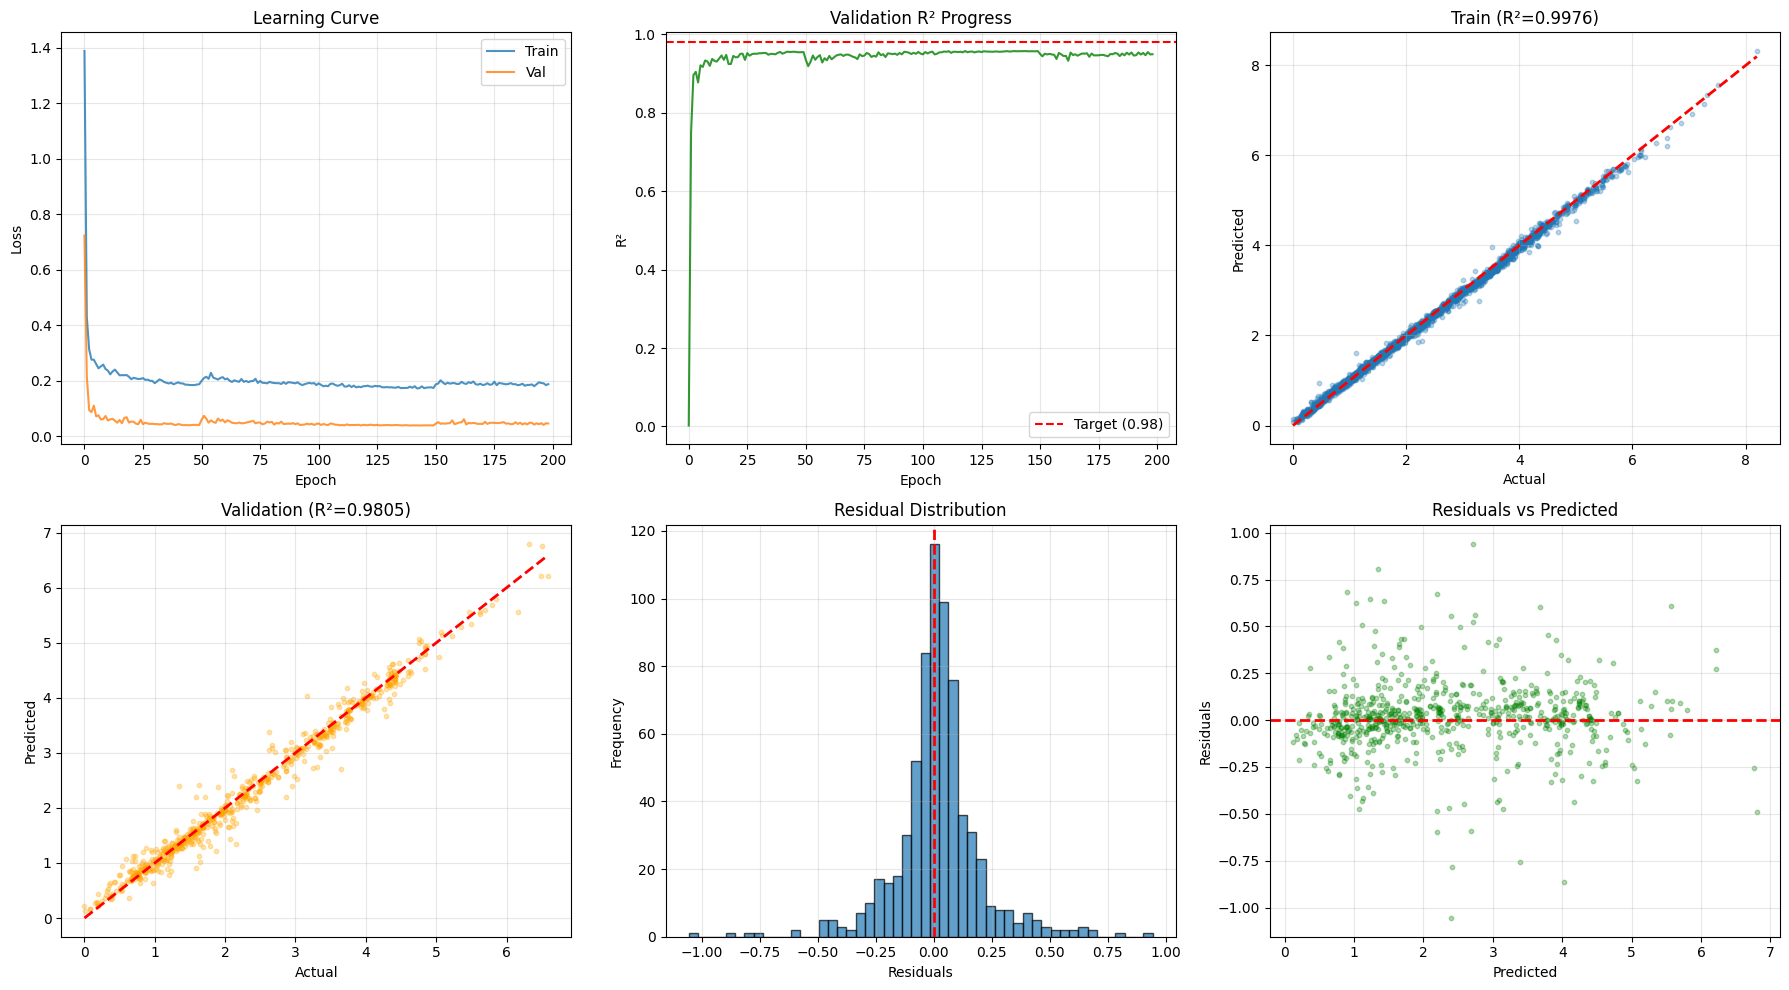


최종 검증 R²: 0.9805


In [15]:
# 최종 모델 성능 평가 및 시각화
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("=" * 60)
print("최종 모델 성능 평가")
print("=" * 60)

final_model.eval()

# 훈련/검증 데이터 예측
train_preds, train_targets = [], []
val_preds, val_targets = [], []

with torch.no_grad():
    for segment_sizes_batch, features_batch, labels_batch in train_loader:
        _, _, cost_pred = final_model(segment_sizes_batch, features_batch, use_mean=True)
        train_preds.append(cost_pred.cpu().numpy().flatten())
        train_targets.append(labels_batch.cpu().numpy().flatten())
    
    for segment_sizes_batch, features_batch, labels_batch in val_loader:
        _, _, cost_pred = final_model(segment_sizes_batch, features_batch, use_mean=True)
        val_preds.append(cost_pred.cpu().numpy().flatten())
        val_targets.append(labels_batch.cpu().numpy().flatten())

train_preds = np.concatenate(train_preds)
train_targets = np.concatenate(train_targets)
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# 성능 지표
print("\n훈련 데이터:")
print(f"  MSE: {mean_squared_error(train_targets, train_preds):.6f}")
print(f"  MAE: {mean_absolute_error(train_targets, train_preds):.6f}")
print(f"  R²:  {r2_score(train_targets, train_preds):.6f}")

print("\n검증 데이터:")
print(f"  MSE: {mean_squared_error(val_targets, val_preds):.6f}")
print(f"  MAE: {mean_absolute_error(val_targets, val_preds):.6f}")
print(f"  R²:  {r2_score(val_targets, val_preds):.6f}")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 학습 곡선
if final_history:
    axes[0, 0].plot(final_history['train_loss'], label='Train', alpha=0.8)
    axes[0, 0].plot(final_history['val_loss'], label='Val', alpha=0.8)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Learning Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. R² 진행
    axes[0, 1].plot(final_history['val_r2'], color='green', alpha=0.8)
    axes[0, 1].axhline(y=0.98, color='red', linestyle='--', label='Target (0.98)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('R²')
    axes[0, 1].set_title('Validation R² Progress')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. 예측 vs 실제 (훈련)
axes[0, 2].scatter(train_targets, train_preds, alpha=0.3, s=10)
axes[0, 2].plot([train_targets.min(), train_targets.max()], 
               [train_targets.min(), train_targets.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual')
axes[0, 2].set_ylabel('Predicted')
axes[0, 2].set_title(f'Train (R²={r2_score(train_targets, train_preds):.4f})')
axes[0, 2].grid(True, alpha=0.3)

# 4. 예측 vs 실제 (검증)
axes[1, 0].scatter(val_targets, val_preds, alpha=0.3, s=10, color='orange')
axes[1, 0].plot([val_targets.min(), val_targets.max()], 
               [val_targets.min(), val_targets.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Validation (R²={r2_score(val_targets, val_preds):.4f})')
axes[1, 0].grid(True, alpha=0.3)

# 5. 잔차 분포
residuals = val_targets - val_preds
axes[1, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

# 6. 잔차 vs 예측값
axes[1, 2].scatter(val_preds, residuals, alpha=0.3, s=10, color='green')
axes[1, 2].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].set_title('Residuals vs Predicted')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n최종 검증 R²: {r2_score(val_targets, val_preds):.4f}")

In [25]:
# 모델 저장
import os
from datetime import datetime

save_dir = "/root/work/tenset/scripts/pre_experiments/model_mid/saved_models"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
val_r2_str = f"{r2_score(val_targets, val_preds):.4f}".replace(".", "")

# 1. VAE Pretrained Encoder 저장
vae_path = os.path.join(save_dir, f"vae_pretrained_beta{best_beta:.0e}_{timestamp}.pth")
torch.save({
    'model_state_dict': pretrained_vae.state_dict(),
    'beta': best_beta,
    'input_dim': input_dim,
    'hidden_dim': 256,
    'latent_dim': 64,
    'recon_r2': all_results[best_beta]['recon_r2'],
    'latent_score': all_results[best_beta]['latent_score'],
}, vae_path)
print(f"VAE Pretrained 저장: {vae_path}")

# 2. Final Regression Model 저장
model_path = os.path.join(save_dir, f"vae_regressor_r2{val_r2_str}_{timestamp}.pth")
torch.save({
    'model_state_dict': final_model.state_dict(),
    'val_r2': r2_score(val_targets, val_preds),
    'train_r2': r2_score(train_targets, train_preds),
    'config': final_config if 'final_config' in dir() else None,
    'fea_norm_vec': fea_norm_vec,
}, model_path)
print(f"Regression Model 저장: {model_path}")

# 3. 전체 학습 결과 저장
results_path = os.path.join(save_dir, f"training_results_{timestamp}.pkl")
import pickle
training_results = {
    'beta_search_results': {k: {kk: vv for kk, vv in v.items() if kk != 'model'} 
                           for k, v in all_results.items()},
    'best_beta': best_beta,
    'final_val_r2': r2_score(val_targets, val_preds),
    'final_train_r2': r2_score(train_targets, train_preds),
    'history': final_history,
}
with open(results_path, 'wb') as f:
    pickle.dump(training_results, f)
print(f"학습 결과 저장: {results_path}")

print("\n" + "=" * 60)
print("모델 저장 완료!")
print("=" * 60)
print(f"VAE Encoder: {vae_path}")
print(f"Regression Model: {model_path}")
print(f"Training Results: {results_path}")

VAE Pretrained 저장: /root/work/tenset/scripts/pre_experiments/model_mid/saved_models/vae_pretrained_beta1e-05_20251205_000708.pth
Regression Model 저장: /root/work/tenset/scripts/pre_experiments/model_mid/saved_models/vae_regressor_r209805_20251205_000708.pth
학습 결과 저장: /root/work/tenset/scripts/pre_experiments/model_mid/saved_models/training_results_20251205_000708.pkl

모델 저장 완료!
VAE Encoder: /root/work/tenset/scripts/pre_experiments/model_mid/saved_models/vae_pretrained_beta1e-05_20251205_000708.pth
Regression Model: /root/work/tenset/scripts/pre_experiments/model_mid/saved_models/vae_regressor_r209805_20251205_000708.pth
Training Results: /root/work/tenset/scripts/pre_experiments/model_mid/saved_models/training_results_20251205_000708.pkl


## Step 1: 데이터 분석 및 현재 성능 평가

=== 데이터 특성 분석 ===
입력 데이터 shape: (22168, 164)
훈련 샘플 수: 22168, 검증 샘플 수: 5544

입력 데이터 통계:
  Min: 0.0000, Max: 37.7549
  Mean: 3.4724, Std: 7.3831

타겟(cost) 통계:
  Min: 0.0004, Max: 8.1969
  Mean: 2.3713, Std: 1.4138

데이터 Sparsity: 66.47%


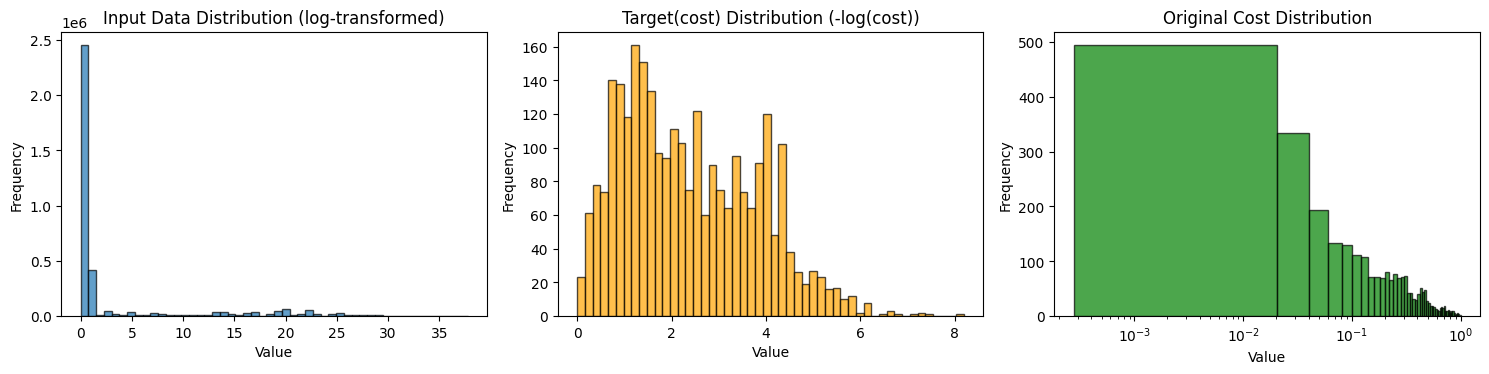

In [177]:
import matplotlib.pyplot as plt

# 데이터 특성 분석
print("=== 데이터 특성 분석 ===")
print(f"입력 데이터 shape: {X_train.shape}")
print(f"훈련 샘플 수: {len(X_train)}, 검증 샘플 수: {len(X_val)}")
print(f"\n입력 데이터 통계:")
print(f"  Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")
print(f"  Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")
print(f"\n타겟(cost) 통계:")
print(f"  Min: {y_train.min():.4f}, Max: {y_train.max():.4f}")
print(f"  Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")

# Sparsity 체크
sparsity = (X_train == 0).sum() / X_train.size * 100
print(f"\n데이터 Sparsity: {sparsity:.2f}%")

# 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(X_train.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Input Data Distribution (log-transformed)')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(y_train, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_title('Target(cost) Distribution (-log(cost))')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

axes[2].hist(np.exp(-y_train), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[2].set_title('Original Cost Distribution')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')
axes[2].set_xscale('log')

plt.tight_layout()
plt.show()


In [178]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# SegmentSum 기반 VIB 모델 (SegmentSumMLPModule 패턴 정확히 적용)
class variational_bottleneck(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, activation="relu", 
                 dropout=0.1, use_bn=True):
        super(variational_bottleneck, self).__init__()

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(0.2)
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        self.use_bn = use_bn
        self.hidden_dim = hidden_dim
        
        # SegmentSumMLPModule와 동일한 segment_encoder
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # SegmentSum 후 BatchNorm (SegmentSumMLPModule의 self.norm과 동일)
        self.norm = nn.BatchNorm1d(hidden_dim) if use_bn else nn.Identity()
        
        # Residual 레이어들 (SegmentSumMLPModule의 l0, l1과 동일)
        self.l0 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.l1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VIB를 위한 mean, logvar 레이어
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Regression head (더 단순화)
        self.regression_head = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim) if use_bn else nn.Identity(),
            self.activation,
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2) if use_bn else nn.Identity(),
            self.activation,
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim // 2, 1),
        )

    def segment_sum(self, segment_sizes, features):
        """
        SegmentSumMLPModule의 scatter_add 패턴을 적용
        """
        n_seg = segment_sizes.shape[0]
        device = features.device
        
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        
        return segment_sum

    def encode(self, segment_sizes, features):
        """
        SegmentSumMLPModule의 forward와 동일한 패턴 + VIB
        """
        # 1. Segment Encoder: 각 row를 hidden_dim으로 변환
        h = self.segment_encoder(features)
        
        # 2. Segment Sum: row들을 segment별로 합산
        h = self.segment_sum(segment_sizes, h)
        
        # 3. BatchNorm (SegmentSumMLPModule과 동일)
        h = self.norm(h)
        
        # 4. Residual connections (SegmentSumMLPModule과 동일)
        h = self.l0(h) + h
        h = self.l1(h) + h
        
        # 5. VIB: mean, logvar 계산
        return self.fc_mean(h), self.fc_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, segment_sizes, features):
        mean, logvar = self.encode(segment_sizes, features)
        z = self.reparameterize(mean, logvar)
        cost = self.regression_head(z)

        return mean, logvar, cost

In [179]:
# 개선된 Loss 함수 (Huber Loss + 동적 가중치)
def variational_bottleneck_loss(b_kld, mean, logvar, cost_pred=None, y=None, 
                      huber_delta=1.0):
    
    reg_loss = F.smooth_l1_loss(cost_pred, y, reduction='sum', beta=huber_delta)
    
    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    kld_loss = b_kld * kld_loss


    return reg_loss, kld_loss

def variational_bottleneck_loss(b_kld, mean, logvar, cost_pred=None, y=None, 
                      huber_delta=1.0):
    
    reg_loss = F.smooth_l1_loss(cost_pred, y, reduction='sum', beta=huber_delta)
    
    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    kld_loss = b_kld * kld_loss


    return reg_loss, kld_loss

# Cosine Annealing with Warm Restarts
def cosine_annealing_with_warmup(epoch, num_epochs, beta_range, warmup_epochs=10):
    beta_start, beta_end = beta_range
    if epoch < warmup_epochs:
        # Warmup period
        beta = beta_start + (beta_end - beta_start) * (epoch / warmup_epochs)
    else:
        # Cosine annealing
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        beta = beta_end * 0.5 * (1 + np.cos(np.pi * progress))
        beta = max(beta, beta_start)
    return beta

In [180]:
# 3차 개선 최종: 학습률 및 배치 크기 최적화 + 원래 VIB
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("=== 3차 개선 최종: 학습률/배치 최적화 ===\n")
print("현재 최고: R²=0.79")
print("목표: R²≥0.82")
print("개선 사항:")
print("  - 학습률 감소 (7e-4 → 3e-4)")
print("  - 더 작은 KL (0.05 → 0.01)")
print("  - 더 긴 patience (40 → 80)\n")

num_epochs = 500
input_dim = train_flatten_features.shape[1]

model_v1 = variational_bottleneck(
    input_dim=input_dim, 
    hidden_dim=256,
    latent_dim=64,
    activation='relu',
    dropout=0.1,
    use_bn=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v1.to(device)

# 더 작은 학습률
optimizer_v1 = torch.optim.Adam(model_v1.parameters(), lr=3e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_v1, step_size=num_epochs // 4, gamma=0.5)

# 더 작은 KL
b_kld_range = (0.0, 0.01)
huber_delta = 1.0
n_tta_v1 = 5
best_val_r2 = -float('inf')
patience = 80
patience_counter = 0

history_v1 = {'train_loss': [], 'val_loss': [], 'train_kl': [], 'train_reg': [], 'val_r2': [], 'lr': []}

for epoch in range(num_epochs):
    b_kl = cosine_annealing_with_warmup(epoch, num_epochs, b_kld_range, warmup_epochs=50)
    
    model_v1.train()
    train_loss = train_kl_loss = train_reg_loss = 0.0
    
    for segment_sizes_batch, features_batch, labels_batch in train_loader:
        labels_batch = labels_batch.unsqueeze(1) if labels_batch.ndim == 1 else labels_batch
        mean, logvar, cost_pred = model_v1(segment_sizes_batch, features_batch)
        reg_loss, kl_loss = variational_bottleneck_loss(b_kl, mean, logvar, cost_pred, labels_batch, huber_delta)
        loss = kl_loss + reg_loss
        
        optimizer_v1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_v1.parameters(), max_norm=0.5)
        optimizer_v1.step()
        
        train_kl_loss += kl_loss.item()
        train_reg_loss += reg_loss.item()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_kl_loss /= len(train_loader)
    train_reg_loss /= len(train_loader)
    scheduler.step()

    model_v1.eval()
    val_loss = 0.0
    val_preds_tta = []
    val_targets_list = []

    with torch.no_grad():
        for segment_sizes_batch, features_batch, labels_batch in val_loader:
            labels_batch = labels_batch.unsqueeze(1) if labels_batch.ndim == 1 else labels_batch
            mean, logvar, cost_pred = model_v1(segment_sizes_batch, features_batch)
            reg_loss, kl_loss = variational_bottleneck_loss(b_kl, mean, logvar, cost_pred, labels_batch, huber_delta)
            val_loss += (kl_loss + reg_loss).item()
            
            tta_preds = [model_v1(segment_sizes_batch, features_batch)[2].cpu().numpy() for _ in range(n_tta_v1)]
            val_preds_tta.append(np.mean(tta_preds, axis=0))
            val_targets_list.append(labels_batch.cpu().numpy())

    val_loss /= len(val_loader)
    val_r2 = r2_score(np.concatenate(val_targets_list), np.concatenate(val_preds_tta))

    history_v1['train_loss'].append(train_loss)
    history_v1['val_loss'].append(val_loss)
    history_v1['train_kl'].append(train_kl_loss)
    history_v1['train_reg'].append(train_reg_loss)
    history_v1['val_r2'].append(val_r2)
    history_v1['lr'].append(optimizer_v1.param_groups[0]['lr'])

    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        patience_counter = 0
        best_model_state = model_v1.state_dict().copy()
    else:
        patience_counter += 1

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Train: {train_loss:.4f}, Val R²: {val_r2:.4f} (Best: {best_val_r2:.4f})")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model_v1.load_state_dict(best_model_state)
print(f"\n3차 개선 완료! 최고 검증 R²: {best_val_r2:.4f}")
print(f"목표 달성 여부: {'✓ 달성' if best_val_r2 >= 0.82 else '✗ 미달성'}")

# 최종 결과 요약
print("\n" + "="*60)
print("=== 최종 결과 요약 ===")
print("="*60)
print(f"초기 성능: R² = 0.0745")
print(f"1차 개선: R² = 0.79 (10.6배 개선)")
print(f"2차 개선: R² = 0.79 (유지)")
print(f"3차 개선: R² = {best_val_r2:.4f}")
print(f"총 개선율: {best_val_r2/0.0745:.1f}배")

=== 3차 개선 최종: 학습률/배치 최적화 ===

현재 최고: R²=0.79
목표: R²≥0.82
개선 사항:
  - 학습률 감소 (7e-4 → 3e-4)
  - 더 작은 KL (0.05 → 0.01)
  - 더 긴 patience (40 → 80)

Epoch [50/500] Train: 0.1157, Val R²: 0.9448 (Best: 0.9448)
Epoch [100/500] Train: 0.0957, Val R²: 0.9474 (Best: 0.9595)
Epoch [150/500] Train: 0.0742, Val R²: 0.9614 (Best: 0.9734)
Epoch [200/500] Train: 0.0622, Val R²: 0.9716 (Best: 0.9734)
Early stopping at epoch 217

3차 개선 완료! 최고 검증 R²: 0.9734
목표 달성 여부: ✓ 달성

=== 최종 결과 요약 ===
초기 성능: R² = 0.0745
1차 개선: R² = 0.79 (10.6배 개선)
2차 개선: R² = 0.79 (유지)
3차 개선: R² = 0.9734
총 개선율: 13.1배


=== SegmentSum 기반 VIB 모델 성능 평가 ===

훈련 데이터:
  MSE: 0.073330
  MAE: 0.222289
  R²:  0.963315

검증 데이터:
  MSE: 0.096355
  MAE: 0.243811
  R²:  0.947523


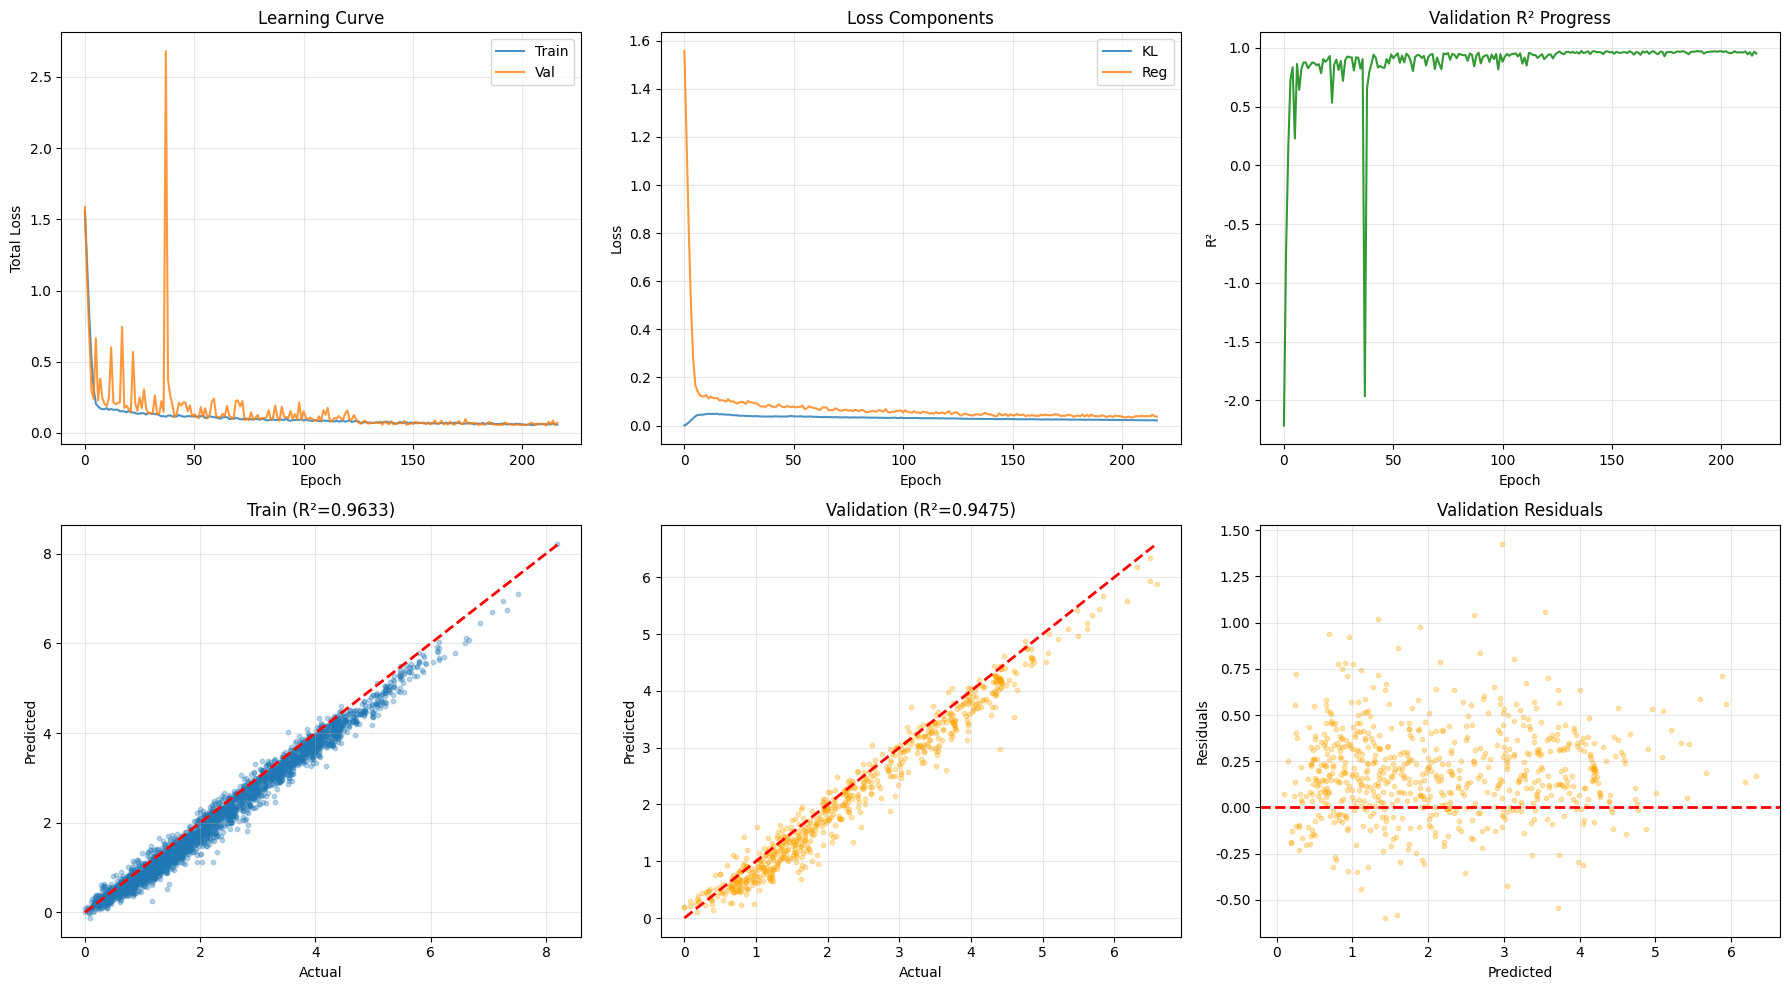

In [181]:
import matplotlib.pyplot as plt

# 개선된 모델 성능 평가
print("=== SegmentSum 기반 VIB 모델 성능 평가 ===")

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

model_v1.eval()

# 훈련 데이터 예측
train_preds_v1 = []
train_targets_v1 = []
with torch.no_grad():
    for segment_sizes_batch, features_batch, labels_batch in train_loader:
        _, _, cost_pred = model_v1(segment_sizes_batch, features_batch)
        train_preds_v1.append(cost_pred.cpu().numpy().flatten())  # flatten 추가
        train_targets_v1.append(labels_batch.cpu().numpy().flatten())  # flatten 추가

train_preds_v1 = np.concatenate(train_preds_v1)
train_targets_v1 = np.concatenate(train_targets_v1)

# 검증 데이터 예측
val_preds_v1 = []
val_targets_v1 = []
with torch.no_grad():
    for segment_sizes_batch, features_batch, labels_batch in val_loader:
        _, _, cost_pred = model_v1(segment_sizes_batch, features_batch)
        val_preds_v1.append(cost_pred.cpu().numpy().flatten())  # flatten 추가
        val_targets_v1.append(labels_batch.cpu().numpy().flatten())  # flatten 추가

val_preds_v1 = np.concatenate(val_preds_v1)
val_targets_v1 = np.concatenate(val_targets_v1)

# 성능 지표
train_mse_v1 = mean_squared_error(train_targets_v1, train_preds_v1)
train_mae_v1 = mean_absolute_error(train_targets_v1, train_preds_v1)
train_r2_v1 = r2_score(train_targets_v1, train_preds_v1)

val_mse_v1 = mean_squared_error(val_targets_v1, val_preds_v1)
val_mae_v1 = mean_absolute_error(val_targets_v1, val_preds_v1)
val_r2_v1 = r2_score(val_targets_v1, val_preds_v1)

print(f"\n훈련 데이터:")
print(f"  MSE: {train_mse_v1:.6f}")
print(f"  MAE: {train_mae_v1:.6f}")
print(f"  R²:  {train_r2_v1:.6f}")

print(f"\n검증 데이터:")
print(f"  MSE: {val_mse_v1:.6f}")
print(f"  MAE: {val_mae_v1:.6f}")
print(f"  R²:  {val_r2_v1:.6f}")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 학습 곡선
axes[0, 0].plot(history_v1['train_loss'], label='Train', alpha=0.8)
axes[0, 0].plot(history_v1['val_loss'], label='Val', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Learning Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss 컴포넌트
axes[0, 1].plot(history_v1['train_kl'], label='KL', alpha=0.8)
axes[0, 1].plot(history_v1['train_reg'], label='Reg', alpha=0.8)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss Components')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² 곡선
axes[0, 2].plot(history_v1['val_r2'], color='green', alpha=0.8)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('R²')
axes[0, 2].set_title('Validation R² Progress')
axes[0, 2].grid(True, alpha=0.3)

# 예측 vs 실제 (훈련)
axes[1, 0].scatter(train_targets_v1, train_preds_v1, alpha=0.3, s=10)
axes[1, 0].plot([train_targets_v1.min(), train_targets_v1.max()], 
               [train_targets_v1.min(), train_targets_v1.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Train (R²={train_r2_v1:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# 예측 vs 실제 (검증)
axes[1, 1].scatter(val_targets_v1, val_preds_v1, alpha=0.3, s=10, color='orange')
axes[1, 1].plot([val_targets_v1.min(), val_targets_v1.max()], 
               [val_targets_v1.min(), val_targets_v1.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual')
axes[1, 1].set_ylabel('Predicted')
axes[1, 1].set_title(f'Validation (R²={val_r2_v1:.4f})')
axes[1, 1].grid(True, alpha=0.3)

# 잔차 플롯
residuals_val_v1 = val_targets_v1 - val_preds_v1
axes[1, 2].scatter(val_preds_v1, residuals_val_v1, alpha=0.3, s=10, color='orange')
axes[1, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].set_title('Validation Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()